# 1. ML data smoothing (harmonization)

### main notebook: https://www.kaggle.com/artyomkolas/result-train-data-smoothing-algorithm

### 1st way: You see it now.

### 2nd way: https://www.kaggle.com/artyomkolas/2-ml-data-smoothing-harmonization-with-contrib

### 3rd way: https://www.kaggle.com/artyomkolas/3-ml-data-smoothing-harmonization-in-columns




## Background

My first competition on kaggle started with a data frame with a lot of missing data, from 0.01% to 99.5% in about 30 columns. Housing Prices. The whole story began with my first ML algorithm for imputation nan into a raw data frame.

LinkedIn post: https://www.linkedin.com/posts/artyomkolas_hi-everyone-i-have-a-nice-news-i-tried-activity-6731588248403001344-Ggg9

notebook: https://www.kaggle.com/artyomkolas/ml-approach-to-replacing-nan-top-4

The essence of the algorithm is to imputation nan with more accurate values ​​in a raw data frame using ML and one click.
The algorithm showed excellent results and without any other improvements (default) of the data frame gave three results (top 11%, top 9%, top 4% in the Housing Prices leaderboard).

Applying other improvements, I was climbing on the leaderboard.
I was already very close to the top 1%. And I decided to very carefully and meticulously replace nan with more appropriate values ​​in each cell !!! without my algorithm with ML nan imputation. And what did I see ?!! The results in predictions (MAE) have become much worse!!!

For a long time I couldn’t understand: Why did the most logical values ​​turn out to be worse? Then he received new knowledge. Participated in new competitions. And I improved my ML nan impooter algorithm. 
Then I got new knowledge. Participated in new competitions. And I improved my ML nan impooter algorithm.


## Hypothesis

The other day the thought came that our world is not ideal. We raise or lower our expectations for purchases or sales, interviews, measurement errors and other factors. A kind of "imputation of subjectivity" and distortions, incl. add outliers.

A hypothesis appeared that the algorithm predicts and inserts, as it were, “more objective” values ​​instead of gaps in accordance with the general field of historical data (“averaged, more objective”). And thus improves the data field (better than real values).

Example: vector of a function (like price)
The lows and highs are the price values.
For example: [30,000, 40,000, 20,000, 23,000, ...]


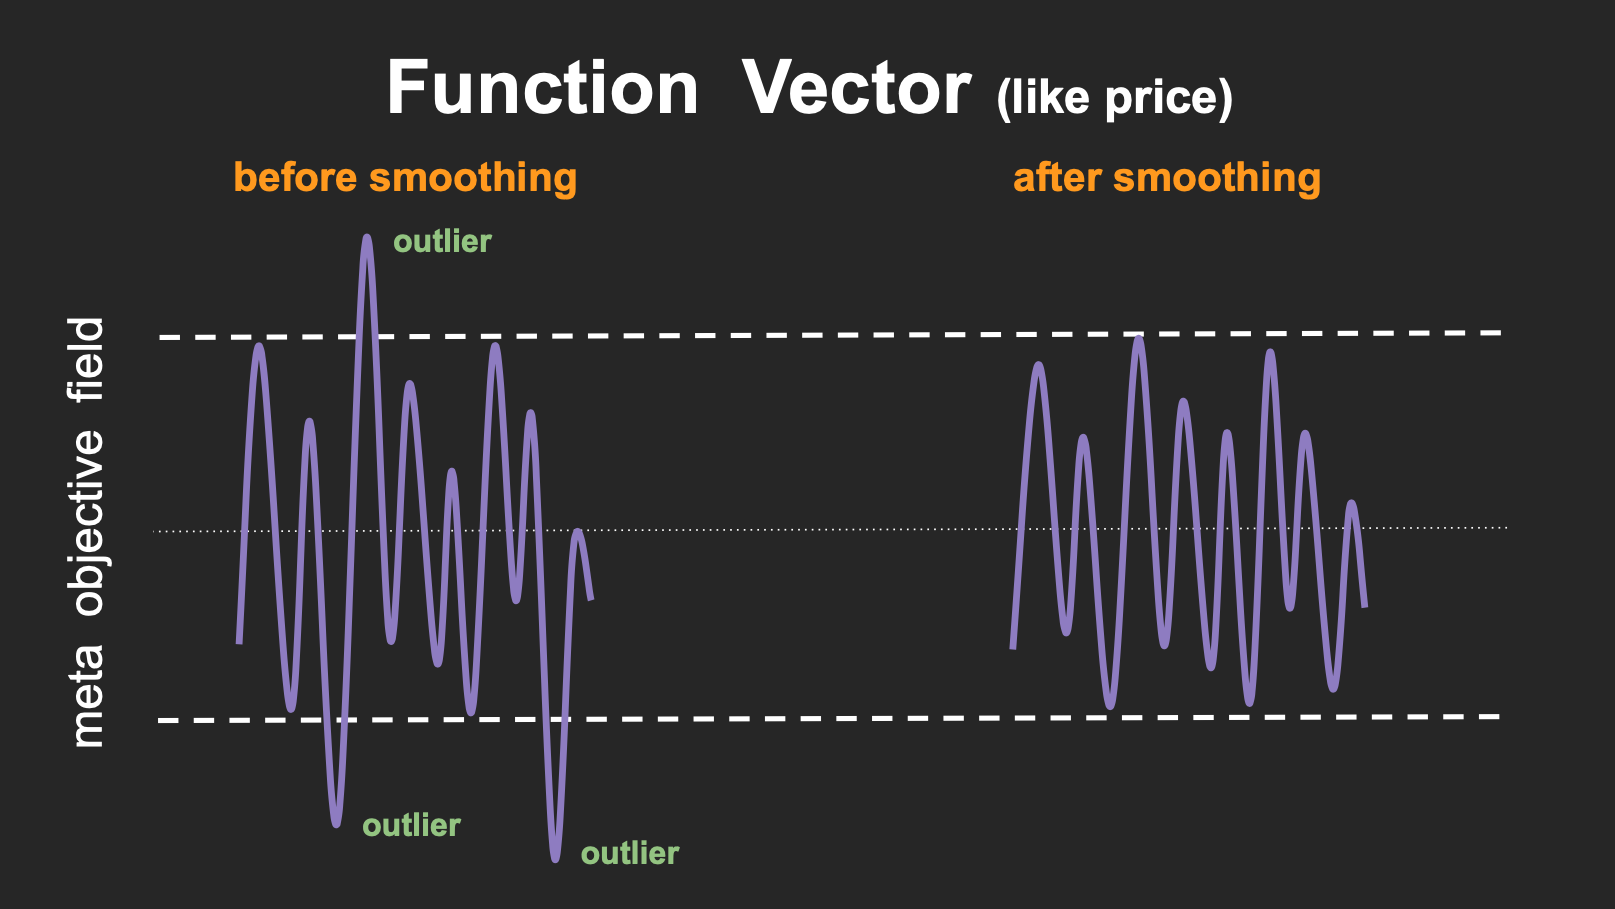

Well. But what if we go all over the data frame and iteratively delete 10% of the data, predict and impute it? Will this help to achieve data harmonization and will it add more objectivity? Will it improve the data for training the model? And finally, does it help train the model more accurately for practical purposes?

# Code

## ML nan imputer

In [ ]:
# ML nan imputer


def nan_predict(df,
                skip_features_from_prediction_where_percent_missing_data_more_than = 100,
                include_features_as_predictors_where_perc_missing_data_less_than = 50,
                apply_fast_predictor_where_missing_data_less_than_percent = 100,
                use_n_rows_for_train_not_more_than = 1000000000,    #  If your dataframe is large
                randomizedSearchCV_iter_plus_perc_missing_data = 10,
                n_estimators_parameter_for_LightGBM = 2000,
                target_feature = None,   # For prediction at the end
                ): 
    
    import random
    import pandas as pd
    import numpy as np

    # Disabling warnings
    import sys
    import warnings
    if not sys.warnoptions:
        warnings.simplefilter("ignore")



    from lightgbm import LGBMClassifier
    from lightgbm import LGBMRegressor
#  _________________________debugging ))____________________________
#     from xgboost import XGBClassifier as LGBMClassifier
#     from xgboost import XGBRegressor as LGBMRegressor
    
    
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    from sklearn.preprocessing import LabelEncoder
    
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    
    

    global counter_all_predicted_values
    counter_all_predicted_values = 0
    
    global numeric_features
    numeric_features = []
    
    global best_params
    
    
    PARAMS  =  {'num_leaves': [12, 50, 120, 200, 300, 400, 500],   #np.arange(200, 600, step=100),
                'max_depth': [4, 8, 12, 16],
                'learning_rate': [0.001, 0.01, 0.1],
                'n_estimators': [n_estimators_parameter_for_LightGBM],
                'subsample': [0.1, 0.3, 0.5],
                'feature_fraction': [0.1, 0.3, 0.5],
                'bagging_fraction': [0.1, 0.3, 0.5],
                'bagging_seed': np.arange(1, 3, step=1),
                'lambda_l1': [0.2],
                'lambda_l2': [0.1],
                'min_child_samples': np.arange(2, 6, step=2),
                'min_split_gain': [0.0001, 0.001]
               }
    
    
    CV = ShuffleSplit(n_splits=2, test_size=0.25, random_state=0)
    
    
    

    def NaN_info(df):
        global null_view
        try:
            null_view = df[[col for col in df.columns if df[col].isna().sum() > 0]].isna().sum().sort_values(ascending = True)
            null_view = pd.DataFrame(null_view, columns=['NANs'])
            null_view[['PERCENT']] = null_view.NANs.apply(lambda x: round((x/len(df))*100, 2))
            null_view[['TYPE']] = df.dtypes
        except:
            return null_view
        return null_view
    
    
    def numeric_features(df):
        num_features = [feature for feature in df.columns if df[feature].dtype in ['int64', 'float64']]
        return num_features
    
    
    def integer_features(df):
        global int_features
        int_features = [feature for feature in df.columns if df[feature].dtype in ['int64']]
        return int_features


    def encoding(work_predictors, df):
        feature_power = 0.5          # Skew handling
        for j in work_predictors:
            el_type = df[j].dtype
            if el_type == 'object':
                df[j].replace(np.nan, 'NoNoNo', inplace=True)
                labelencoder = LabelEncoder()
                df.loc[:, j] = labelencoder.fit_transform(df.loc[:, j])
            else:
                df[j] = df[j]**feature_power
        return df, work_predictors


    def hyperparms_tuning(CV, X_train, X_test, y_train, y_test, n_iter_for_RandomizedSearchCV, PARAMS, alg, scoring):
        global best_params
        global pred_test_lgb

        lgbm = alg(random_state = 0)
        lgbm_randomized = RandomizedSearchCV(estimator=lgbm, 
                                            param_distributions=PARAMS, 
                                            n_iter=n_iter_for_RandomizedSearchCV, 
                                            scoring=scoring, 
                                            cv=CV, 
                                            verbose=0,
                                            n_jobs = -1)

        lgbm_randomized.fit(X_train, y_train)
        
        best_params = lgbm_randomized.best_params_
        pred_test_lgb = lgbm_randomized.predict(X_test)
        return best_params, pred_test_lgb

    
    def predict_regressor(best_params, X, y, miss_df):
        print('Best parameters:')
        print(best_params)
        print('')
        global pred_miss
        lgbm = LGBMRegressor(**best_params, n_jobs=-1, random_state=0)
        lgbm = lgbm.fit(X, y)
        pred_miss = list(lgbm.predict(miss_df))
        print('-------------------------------')
#         print(f"The first 100 predicted missing values: \n{pred_miss[:100]}")
        return pred_miss


    def predict_classifier(best_params, X, y, miss_df):
        print('Best parameters:')
        print(best_params)
        print('')
        global pred_miss
        lgbm = LGBMClassifier(**best_params, n_jobs=-1, random_state=0)
        lgbm = lgbm.fit(X, y)
        pred_miss = list(lgbm.predict(miss_df))
        print('-------------------------------')
#         print(f"The first 100 predicted missing values: \n{pred_miss[:100]}")
        return pred_miss
    
    
    def imput_missing_value_to_main_df(df, miss_indeces, pred_miss, el):
        df.loc[miss_indeces, el] = pred_miss[:]
        return df
    
    
    
    
    # Go)

    plt.figure(figsize=(20, 5))
    sns.heatmap(df.isnull(), cbar=False)
    
    
    print(NaN_info(df))
#     print('\n\n\n')
    
    all_features = list(df.columns)
    df_indeces = list(df.index)
    df.reset_index(drop=True, inplace=True)
    
    integer_features(df)

    delete_miss_features = list(
        (null_view.loc[null_view['PERCENT'] > skip_features_from_prediction_where_percent_missing_data_more_than]).index)
#     print(f'Exclude from the prediction, because missing data more than \
#     {skip_features_from_prediction_where_percent_missing_data_more_than}% :\n{delete_miss_features}')
#     print('')
    all_miss_features = list(null_view.index)

    for delete_feature in delete_miss_features:
        all_miss_features.remove(delete_feature)
        
    
    if target_feature in all_miss_features:  # moving target_feature to end of the prediction
        all_miss_features.append(all_miss_features.pop(all_miss_features.index(target_feature)))
        
    
    for el in all_miss_features:
#         print('\n')
        
        # select features as predictors
        NaN_info(df)
        lot_of_miss_features = list(
            (null_view.loc[null_view['PERCENT'] > include_features_as_predictors_where_perc_missing_data_less_than]).index)
        now_predictors = list(set(all_features)-set(lot_of_miss_features))
        work_predictors = list(set(now_predictors) - set([el]))

        
        # missing data (data for prediction)
        miss_indeces = list((df[pd.isnull(df[el])]).index)
        miss_df = df.iloc[miss_indeces][:]
        miss_df = miss_df[work_predictors]
        encoding(work_predictors, df=miss_df)

        
        # data without NaN rows (X data for train, evaluation of model)
        work_indeces = list(set(df_indeces) - set(miss_indeces))
        if len(work_indeces) > use_n_rows_for_train_not_more_than:
            randomlist = random.sample(range(0, len(work_indeces)), use_n_rows_for_train_not_more_than)
            work_indeces = [work_indeces[i] for i in randomlist]
        
        work_df = df.iloc[work_indeces][:]
        encoding(work_predictors, df=work_df)
        X = work_df[work_predictors]
        y = work_df[el]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

        
        # Info
        feature_type = df[el].dtypes
        percent_missing_data = null_view['PERCENT'][el]
#         print(f'Feature: {el},   type: {feature_type},   missing values: {percent_missing_data}%\n')    
#         print(f'Shape for train dataframe: {(X.shape)}')
#         print(f'Unused features as predictors, because missing data more than {include_features_as_predictors_where_perc_missing_data_less_than}% :')
#         print(lot_of_miss_features)
#         print('')
        
        
        # PREDICTIONS
        if percent_missing_data < apply_fast_predictor_where_missing_data_less_than_percent:
            
            # FAST Predictions without tuning hyperparameters
            
            print('FAST prediction without tuning hyperparameters\n')
            best_params = {}
            if feature_type == 'object' or feature_type == 'bool':
                print('FAST CLASSIFIER:')
                labelencoder = LabelEncoder()
                y_train = labelencoder.fit_transform(y_train)
                y_test = labelencoder.fit_transform(y_test)
                lgbm = LGBMClassifier(n_jobs=-1, random_state=0)
                lgbm = lgbm.fit(X_train, y_train)
                
                pred_test_lgb_FAST = lgbm.predict(X_test)
                accuracy = accuracy_score(y_test, pred_test_lgb_FAST)
                print('Evaluations:')
                print(f'first 10 y_test: {y_test[:10]}')
                print(f'first 10 y_pred: {pred_test_lgb_FAST[:10]}\n')
                f1 = f1_score(y_test, pred_test_lgb_FAST, average='weighted')
                print(f'accuracy_score:      {accuracy}')
                print(f'f1_score (weighted): {f1}')
                
                predict_classifier(best_params, X, y, miss_df)
                counter_all_predicted_values += len(miss_indeces)
                imput_missing_value_to_main_df(df, miss_indeces, pred_miss, el)

            elif feature_type == 'float64' or feature_type == 'int64':
                print('FAST REGRESSOR:')
                
                lgbm = LGBMRegressor(n_jobs=-1, random_state=0)
                lgbm = lgbm.fit(X_train, np.log1p(y_train))

                pred_test_lgb_FAST = lgbm.predict(X_test)
                pred_test_lgb_FAST = np.expm1(pred_test_lgb_FAST)
                MAE = mean_absolute_error(y_test,pred_test_lgb_FAST)
                y_te = list(round(y_test[:10], 1))
                y_pred = list(np.round(pred_test_lgb_FAST[:10], 1))
                print('Evaluations:')
                print(f'first 10 y_test: {y_te}')
                print(f'first 10 y_pred: {y_pred}\n')
                print(f'mean_absolute_error: {MAE}')
                print(f'mean for {el}: {df[el].mean()}')
                
                predict_regressor(best_params, X, y, miss_df)
                counter_all_predicted_values += len(miss_indeces)
                imput_missing_value_to_main_df(df, miss_indeces, pred_miss, el)

            else:
                print(f"unprocessed feature: {el} - {feature_type} type")
                
                  
        else:
            
            # ADVANCED Predictions with tuning hyperparameters
            
            n_iter_for_RandomizedSearchCV = int(randomizedSearchCV_iter_plus_perc_missing_data + percent_missing_data * 1)
            print(f'Iteration for RandomizedSearchCV: {n_iter_for_RandomizedSearchCV}\n')
            
            if feature_type == 'object' or feature_type == 'bool':
                print('ADVANCED CLASSIFIER:')
                labelencoder = LabelEncoder()
                y_train = labelencoder.fit_transform(y_train)
                y_test = labelencoder.fit_transform(y_test)
                hyperparms_tuning(CV, X_train, X_test, y_train, y_test, n_iter_for_RandomizedSearchCV, PARAMS, alg=LGBMClassifier, scoring='f1_weighted')
                accuracy = accuracy_score(y_test, pred_test_lgb)
                print('Evaluations:')
                print(f'first 10 y_test: {y_test[:10]}')
                print(f'first 10 y_pred: {pred_test_lgb[:10]}\n')
                f1 = f1_score(y_test, pred_test_lgb, average='weighted')
                print(f'accuracy_score:      {accuracy}')
                print(f'f1_score (weighted): {f1}')
                
                predict_classifier(best_params, X, y, miss_df)
                counter_all_predicted_values += len(miss_indeces)
                imput_missing_value_to_main_df(df, miss_indeces, pred_miss, el)

            elif feature_type == 'float64' or feature_type == 'int64':
                print('ADVANCED REGRESSOR:')
                hyperparms_tuning(CV, X_train, X_test, y_train, y_test, n_iter_for_RandomizedSearchCV, PARAMS, alg=LGBMRegressor, scoring='neg_mean_squared_error')
                MAE = mean_absolute_error(y_test,pred_test_lgb)
                y_te = list(round(y_test[:10], 1))
                y_pred = list(np.round(pred_test_lgb[:10], 1))
                print('Evaluations:')
                print(f'first 10 y_test: {y_te}')
                print(f'first 10 y_pred: {y_pred}\n')
                print(f'mean_absolute_error: {MAE}')
                print(f'mean for {el}: {df[el].mean()}')
                
                predict_regressor(best_params, X, y, miss_df)
                counter_all_predicted_values += len(miss_indeces)
                imput_missing_value_to_main_df(df, miss_indeces, pred_miss, el)

            else:
                print(f"unprocessed feature: {el} - {feature_type} type")
        
        del now_predictors
        del work_predictors
        del miss_indeces
        del miss_df        
        del work_df
        del X
        del y
        del X_train
        del X_test
        del y_train
        del y_test
        del pred_test_lgb_FAST
        
        
    plt.figure(figsize=(20, 5))
    sns.heatmap(df.isnull(), cbar=False)



        
    for feature in int_features:
        df[[feature]] = df[[feature]].astype('int64')
        
    df.index = df_indeces

#     print('\n\n\n')
#     print(f'These features have not been processed, because missing data more than {skip_features_from_prediction_where_percent_missing_data_more_than}%')
#     print(NaN_info(df))
#     print('\n\n\n')
#     print(f'{counter_all_predicted_values} values have been predicted and replaced')
#     print('\n')
    
    del counter_all_predicted_values
    del numeric_features

    return df

# Let's choose data, the target feature and middle of data¶
# 200 rows!!!

In [ ]:
import numpy as np
import pandas as pd


test_size_fraction = 0.5

num_rows = 200 


data = "../input/fe-course-data/concrete.csv"
target_feature = "CompressiveStrength"


# data = "../input/fe-course-data/housing.csv"
# target_feature = "HouseAge"


# data = "../input/fe-course-data/autos.csv"
# target_feature = "price"



df = pd.read_csv(data)

df

In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)

# num rows

In [ ]:
df = df.iloc[:][:num_rows]
df

# encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder


def encoding(df):
    for j in df.columns:
        el_type = df[j].dtype
        if el_type == 'object':
            df[j].replace(np.nan, 'NoNoNo', inplace=True)
            labelencoder = LabelEncoder()
            df.loc[:, j] = labelencoder.fit_transform(df.loc[:, j])
    return df

encoding(df)

# normalization

In [ ]:
predictors = list(df.columns)
predictors.remove(target_feature)

for col in predictors:
    min_x = df[[col]].min()
    max_x = df[[col]].max()
    df[[col]] = (df[[col]] - min_x) / (max_x - min_x)
df

# Let's split data to train and test.

In [ ]:
from sklearn.model_selection import train_test_split


predictors = list(df.columns)
predictors.remove(target_feature)

X = df[predictors]
y = df[[target_feature]]


train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size_fraction, random_state=0)

train_X.reset_index(drop=True, inplace=True)
test_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)


print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

# MAE Baseline Score

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
def baseline_score(train_X, train_y, test_X, test_y):
    baseline_model = LGBMRegressor(random_state=0).fit(train_X, train_y)
    baseline_predict = baseline_model.predict(test_X)
    baseline_score = mean_absolute_error(baseline_predict, test_y)

    print(f"MAE Baseline Score: {baseline_score}")
    return baseline_score

# Data smoothing

In [ ]:
def iteration_smoothing(df, iteration):
    indexes = df.index
    print('\n')
    print(f'iteration: ===================================== {iteration} ===================================== ')
    for col in df.columns:
        ITERATON = str(iteration)[-1]
        iteration_indexes = []
        for el in indexes:
            if str(el)[-1] == ITERATON:
                iteration_indexes.append(el)

        print('first ten indexes for nan imputation and next ML prediction (smoothing)')
        print(iteration_indexes[:10])
        iteration += 1

        df.loc[iteration_indexes,col] = np.nan
        nan_predict(df)
    return df

In [ ]:
def score(train_X, train_y, test_X, test_y):
    model = LGBMRegressor(random_state=0).fit(train_X, train_y)
    predict = model.predict(test_X)
    score = mean_absolute_error(predict, test_y)

    print(f"MAE Score: {score}")
    return score

In [ ]:
results = pd.DataFrame()
results.loc[0, 'score'] = baseline_score(train_X, train_y, test_X, test_y)

for num in range(0,10):
    iteration_smoothing(train_X, num)
    results.loc[num*10+10, 'score'] = score(train_X, train_y, test_X, test_y)


In [ ]:
import plotly.graph_objs as go
import plotly.offline as py


baseline = []
for el in range(0,11):
    baseline.append(results.loc[0,'score'])


trace1 = go.Scatter(
                    x=results.index, 
                    y=baseline, 
                    name="without smoothing", 
                    marker=dict(color = '#FFB3F7',
                             line=dict(color='#000000',width=1)))




trace2 = go.Scatter(
                    x=results.index, 
                    y=results['score'], 
                    name="smoothing iterations", 
                    marker=dict(color = '#47E0FF',
                             line=dict(color='#000000',width=1)))

layout = go.Layout(hovermode='closest', 
                   title = f'MAE after every iteration for feature: "{target_feature}"    for {data}', 
                   xaxis = dict(title = 'smoothed data, %'), 
                   yaxis = dict(title = 'Mean Absolute Error'), 
                   template= "plotly_dark")

fig = go.Figure(data = [trace1, trace2], layout=layout)
fig.show()

### AND for 
### data = "../input/fe-course-data/housing.csv"
### target_feature = "HouseAge"

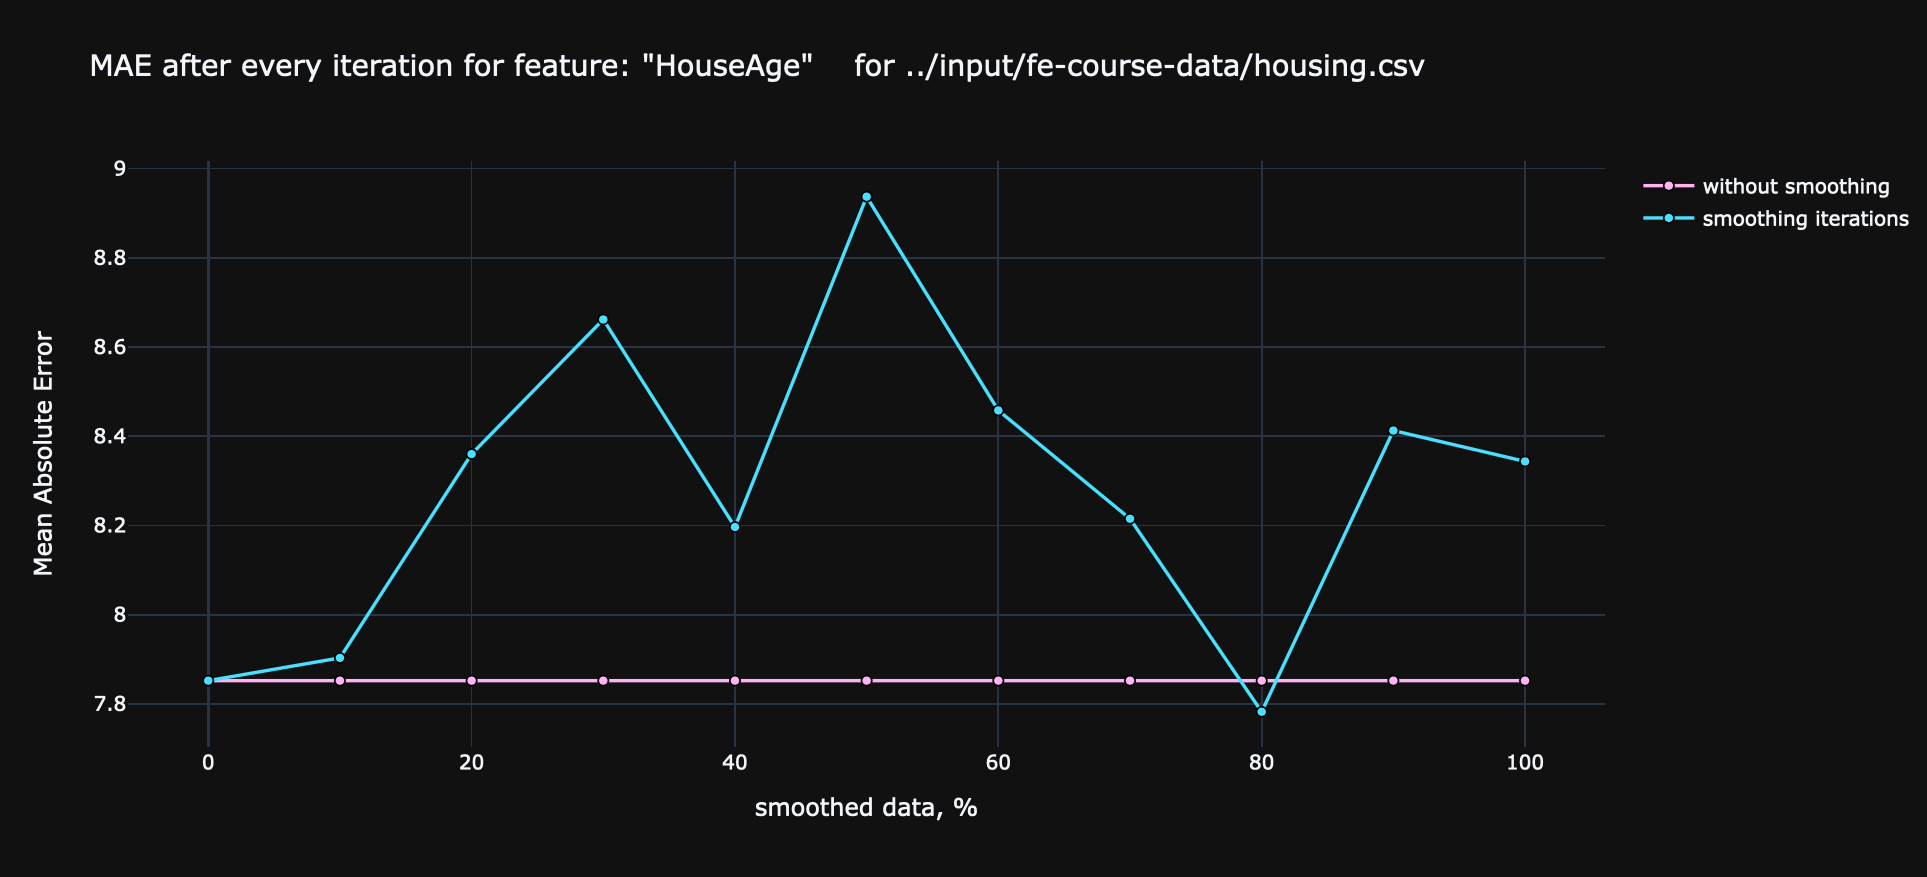

### AND for 
### data = "../input/fe-course-data/autos.csv"
### target_feature = "price"

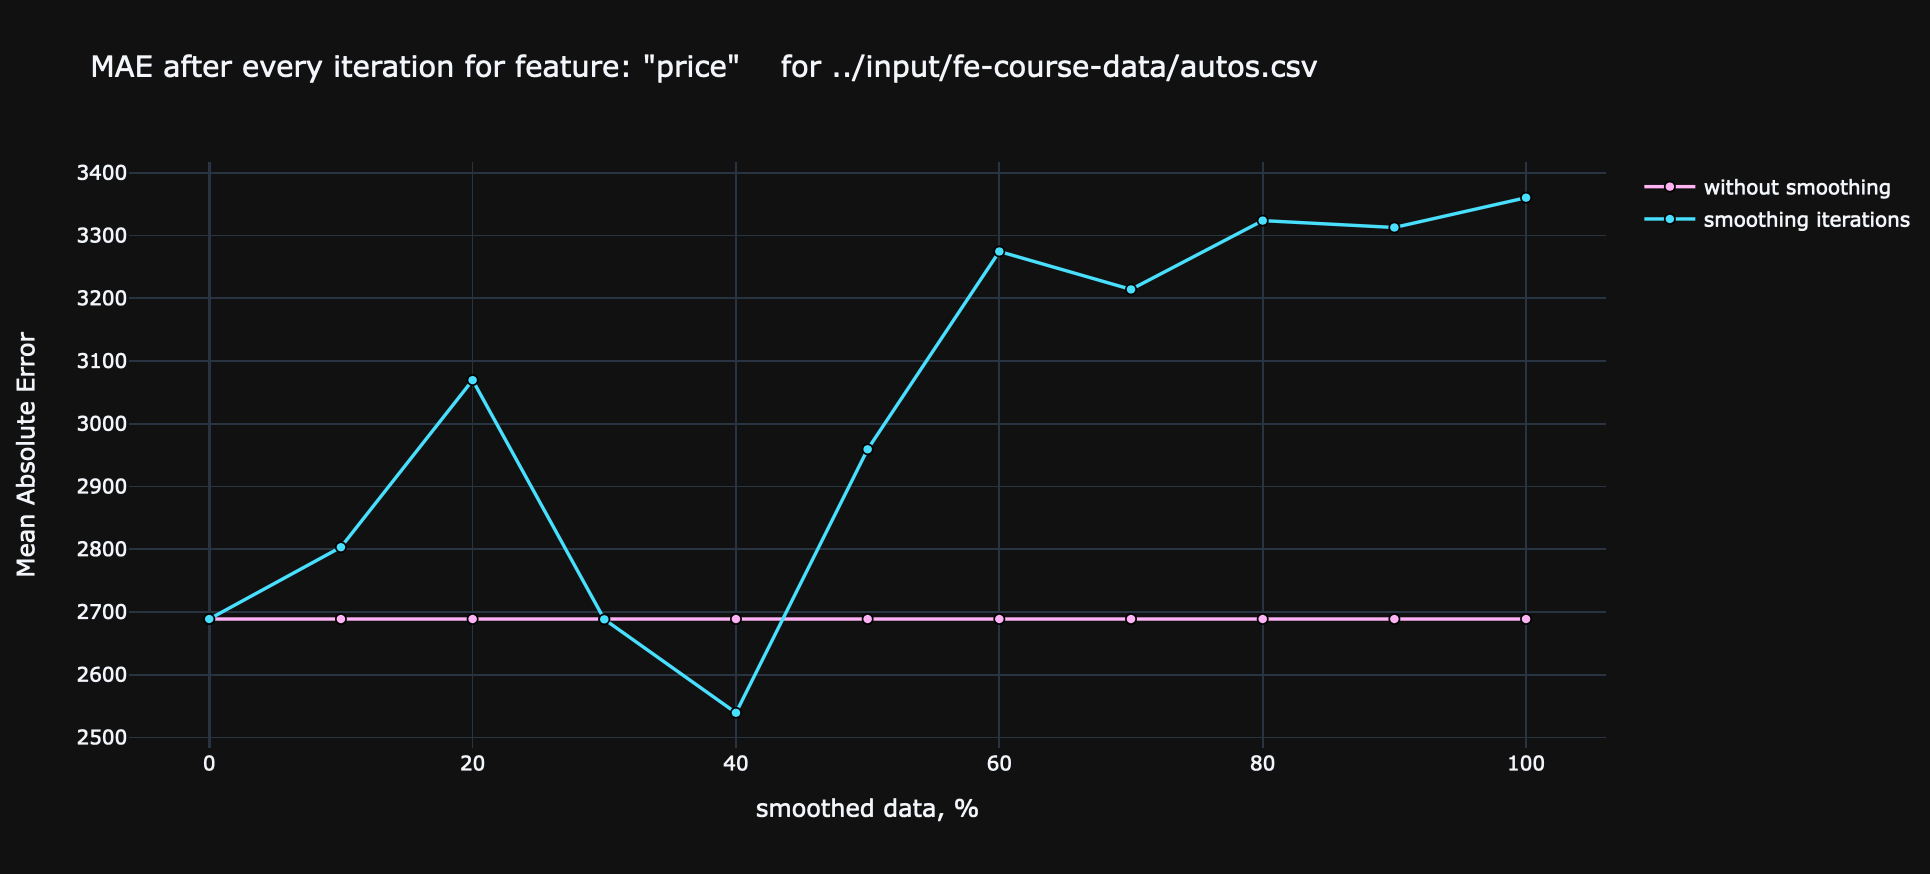